In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
data = np.load('data_128units.npz')

X1_obs = data['X1_obs']
X1_h1 = data['X1_h1']
X1_h2 = data['X1_h2']
X1_act = data['X1_act']
X2_obs = data['X2_obs']
X2_h1 = data['X2_h1']
X2_h2 = data['X2_h2']
X2_act = data['X2_act']
X3_obs = data['X3_obs']
X3_h1 = data['X3_h1']
X3_h2 = data['X3_h2']
X3_act = data['X3_act']
y1 = data['y1']
y2 = data['y2']
y3 = data['y3']

In [265]:
def train_and_test(X, y):
    # only episodes where the other agent covers just one landmark 
    idx = np.where(np.sum(y, axis=-1) == 1)[0]
    X = X[idx]
    y = y[idx]

    # duplicate the last step landmark data over all episode timesteps
    y = y[:, np.newaxis, :]
    y = y.repeat(X.shape[1], axis=1)
    y = np.argmax(y, axis=-1) # convert one-hot vector into indices

    # split into training and test episodes (NB! this is done at episode level!)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

    # use only middle 5 steps for testing
    X_test = X_test[:, 10:15]
    y_test = y_test[:, 10:15]
    
    # get rid of the episode dimension
    X_train = X_train.reshape((-1, X.shape[2]))
    X_test = X_test.reshape((-1, X.shape[2]))
    y_train = y_train.reshape((-1,))
    y_test = y_test.reshape((-1,))

    # normalize input features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train linear classifier
    #clf = SVC(kernel='linear', C=1, cache_size=1000)
    #clf = LinearSVC(C=1)
    #clf = SGDClassifier()
    #clf = LinearDiscriminantAnalysis()
    clf = MLPClassifier(hidden_layer_sizes=tuple(), solver='adam')
    clf.fit(X_train, y_train)

    # calculate training and test accuracy
    return clf.score(X_train, y_train), clf.score(X_test, y_test)

In [235]:
acc = np.empty((3, 3, 4, 2))
for i in range(3):
    for j in range(3):
        acc[i, j, 0] = train_and_test(data['X%d_obs' % (i + 1)], data['y%d' % (j + 1)])
        acc[i, j, 1] = train_and_test(data['X%d_h1' % (i + 1)], data['y%d' % (j + 1)])
        acc[i, j, 2] = train_and_test(data['X%d_h2' % (i + 1)], data['y%d' % (j + 1)])
        acc[i, j, 3] = train_and_test(data['X%d_act' % (i + 1)], data['y%d' % (j + 1)])

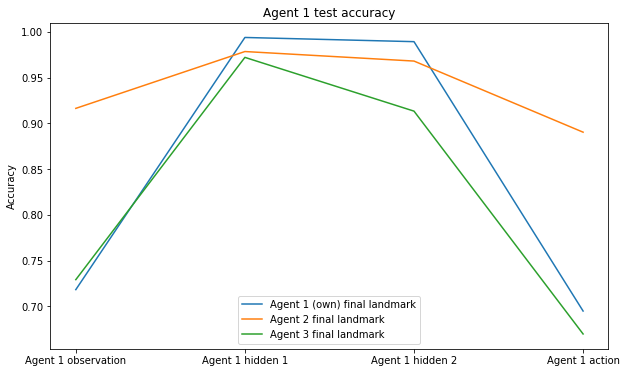

In [262]:
plt.figure(figsize=(10, 6))
plt.plot(acc[0, :, :, 1].T)
plt.ylabel('Accuracy')
#plt.xlabel('Features')
plt.title('Agent 1 test accuracy')
plt.xticks(range(4), ['Agent 1 observation', 'Agent 1 hidden 1', 'Agent 1 hidden 2', 'Agent 1 action'])
plt.legend(['Agent 1 (own) final landmark', 'Agent 2 final landmark', 'Agent 3 final landmark'], loc='lower center')

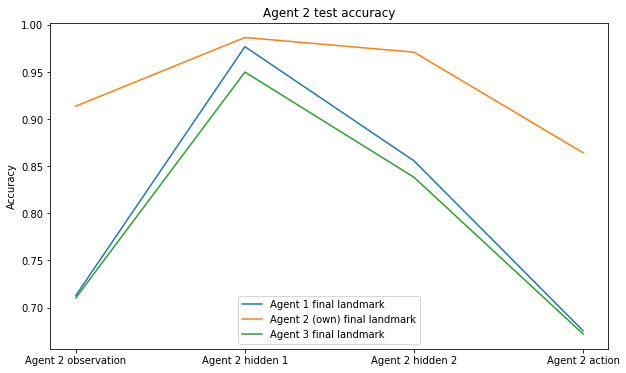

In [263]:
plt.figure(figsize=(10, 6))
plt.plot(acc[1, :, :, 1].T)
plt.ylabel('Accuracy')
#plt.xlabel('Features')
plt.title('Agent 2 test accuracy')
plt.xticks(range(4), ['Agent 2 observation', 'Agent 2 hidden 1', 'Agent 2 hidden 2', 'Agent 2 action'])
plt.legend(['Agent 1 final landmark', 'Agent 2 (own) final landmark', 'Agent 3 final landmark'], loc='lower center')

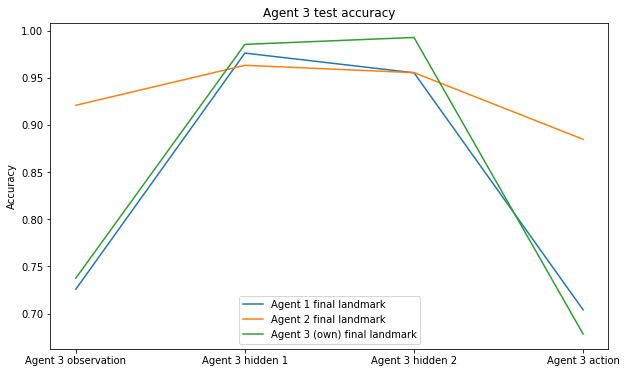

In [264]:
plt.figure(figsize=(10, 6))
plt.plot(acc[2, :, :, 1].T)
plt.ylabel('Accuracy')
#plt.xlabel('Features')
plt.title('Agent 3 test accuracy')
plt.xticks(range(4), ['Agent 3 observation', 'Agent 3 hidden 1', 'Agent 3 hidden 2', 'Agent 3 action'])
plt.legend(['Agent 1 final landmark', 'Agent 2 final landmark', 'Agent 3 (own) final landmark'], loc='lower center')

In [3]:
def train_and_test_timestep(X, y, t):
    # only episodes where the other agent covers just one landmark 
    idx = np.where(np.sum(y, axis=-1) == 1)[0]
    X = X[idx, t]
    y = y[idx]

    # convert one-hot vector into indices
    y = np.argmax(y, axis=-1)

    # split into training and test episodes (NB! this is done at episode level!)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

    # normalize input features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train linear classifier
    #clf = SVC(kernel='linear', C=1, cache_size=1000)
    #clf = LinearSVC(C=1)
    #clf = SGDClassifier()
    #clf = LinearDiscriminantAnalysis()
    clf = MLPClassifier(hidden_layer_sizes=(), solver='adam')
    clf.fit(X_train, y_train)

    # calculate training and test accuracy
    return clf.score(X_train, y_train), clf.score(X_test, y_test)

In [4]:
acc = np.empty((3, 3, 25, 4, 2))
for i in range(3):
    for j in range(3):
        for t in range(25):
            print(i, j, t, end=' ')
            acc[i, j, t, 0] = train_and_test_timestep(data['X%d_obs' % (i + 1)], data['y%d' % (j + 1)], t)
            acc[i, j, t, 1] = train_and_test_timestep(data['X%d_h1' % (i + 1)], data['y%d' % (j + 1)], t)
            acc[i, j, t, 2] = train_and_test_timestep(data['X%d_h2' % (i + 1)], data['y%d' % (j + 1)], t)
            acc[i, j, t, 3] = train_and_test_timestep(data['X%d_act' % (i + 1)], data['y%d' % (j + 1)], t)
            print(acc[i, j, t, :, 1])

0 0 0 

/home/tambet/.conda/envs/multi/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.5908558  0.88159437 0.91910903 0.60375147]
0 0 1 [0.5873388  0.92614302 0.92028136 0.61899179]
0 0 2 [0.58499414 0.94021102 0.92966002 0.59320047]
0 0 3 [0.60609613 0.94255569 0.94255569 0.5908558 ]
0 0 4 [0.56740914 0.95779601 0.94255569 0.59202814]
0 0 5 [0.60375147 0.96131301 0.96483001 0.5908558 ]
0 0 6 [0.5908558  0.96248535 0.96951934 0.56154748]
0 0 7 [0.56506448 0.98124267 0.98241501 0.6014068 ]
0 0 8 [0.55216882 0.97772567 0.97655334 0.61430246]
0 0 9 [0.5908558  0.98475967 0.989449   0.55920281]
0 0 10 [0.60961313 0.99531067 0.98827667 0.60961313]
0 0 11 [0.57209848 0.996483   0.996483   0.57913247]
0 0 12 [0.62368113 0.99531067 0.985932   0.56271981]
0 0 13 [0.62016413 0.992966   0.99179367 0.58616647]
0 0 14 [0.62485346 0.99413834 0.99179367 0.59320047]
0 0 15 [0.65416178 0.99765533 0.996483   0.58030481]
0 0 16 [0.62016413 0.99413834 0.98827667 0.5873388 ]
0 0 17 [0.56740914 0.99882767 0.992966   0.56858148]
0 0 18 [0.6119578  0.996483   0.99413834 0.6084408 ]
0 0 19 [0

2 0 6 [0.57913247 0.97538101 0.96014068 0.59320047]
2 0 7 [0.56389215 0.97772567 0.97889801 0.53692849]
2 0 8 [0.59202814 0.98241501 0.97655334 0.54279015]
2 0 9 [0.58382181 0.98358734 0.98710434 0.57561547]
2 0 10 [0.61547479 0.98827667 0.98124267 0.60375147]
2 0 11 [0.58264947 0.98710434 0.985932   0.58968347]
2 0 12 [0.60726846 0.99413834 0.98241501 0.58382181]
2 0 13 [0.62485346 0.989449   0.99062134 0.58147714]
2 0 14 [0.64243845 0.992966   0.99413834 0.6119578 ]
2 0 15 [0.59906213 0.99413834 0.992966   0.60375147]
2 0 16 [0.56975381 0.99179367 0.992966   0.61430246]
2 0 17 [0.56858148 0.99765533 0.99179367 0.64126612]
2 0 18 [0.62250879 0.992966   0.99179367 0.62133646]
2 0 19 [0.58851114 0.99531067 0.992966   0.64478312]
2 0 20 [0.62250879 0.99531067 0.99413834 0.63071512]
2 0 21 [0.61313013 0.99531067 0.99179367 0.63540445]
2 0 22 [0.5908558  0.99765533 0.992966   0.63423212]
2 0 23 [0.61781946 0.99413834 0.99062134 0.6119578 ]
2 0 24 [0.61547479 0.99062134 0.992966   0.6506447

## Training accuracy

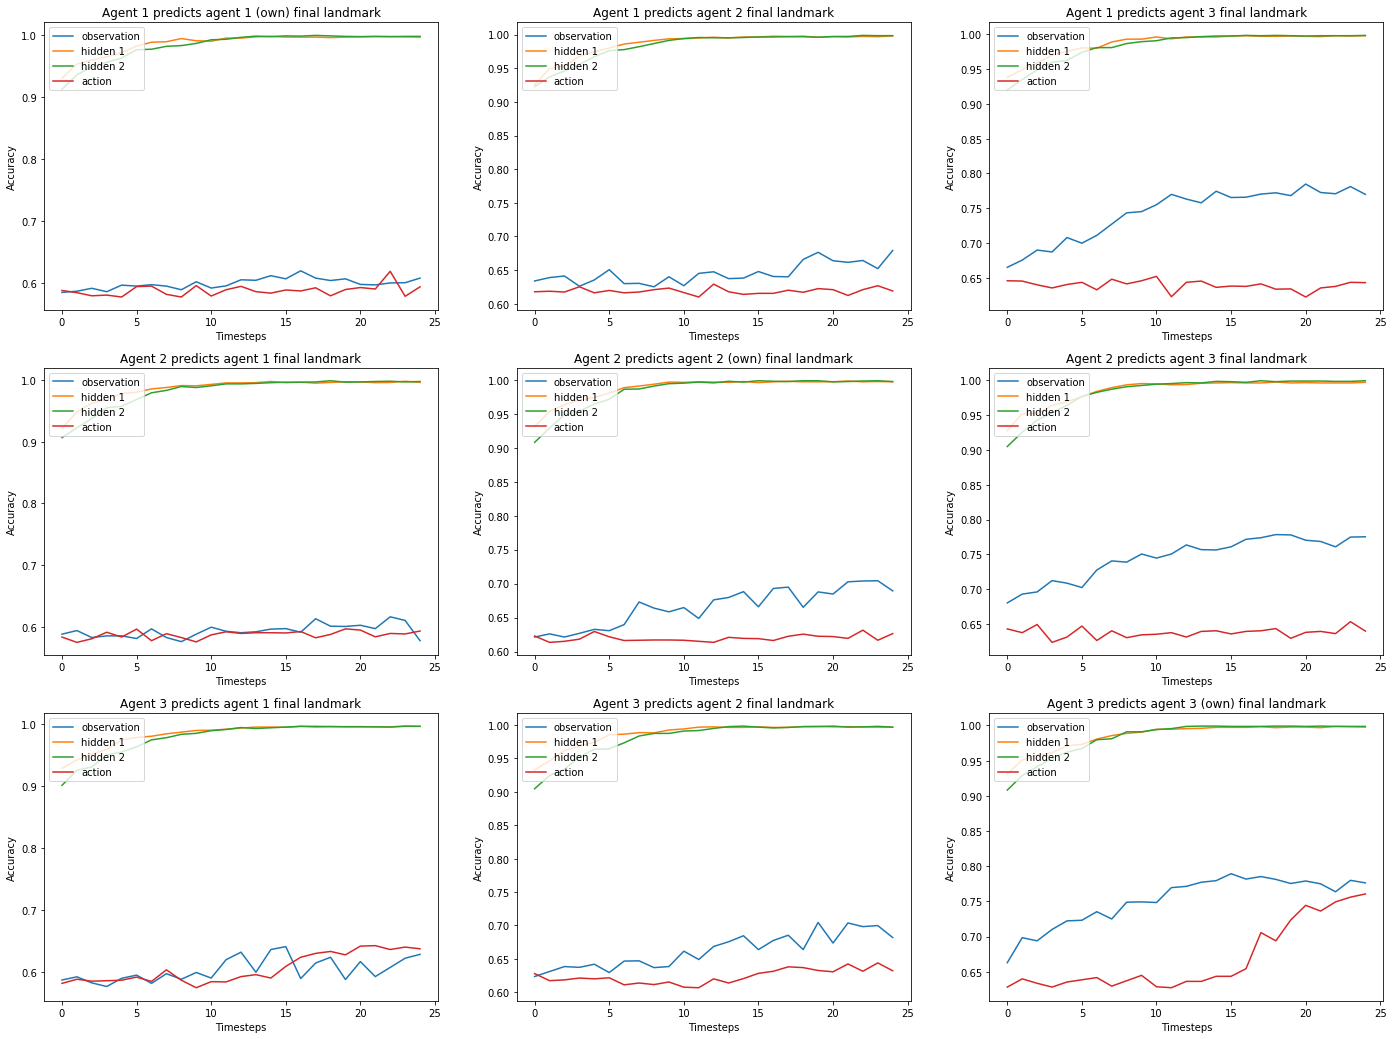

In [6]:
plt.figure(figsize=(24, 18))
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i*3 + j + 1)
        plt.plot(acc[i, j, :, :, 0])
        plt.ylabel('Accuracy')
        plt.xlabel('Timesteps')
        plt.title('Agent %d predicts agent %d%s final landmark' % (i + 1, j + 1, ' (own)' if i == j else ''))
        plt.legend(['observation', 'hidden 1', 'hidden 2', 'action'], loc='upper left')

## Test accuracy

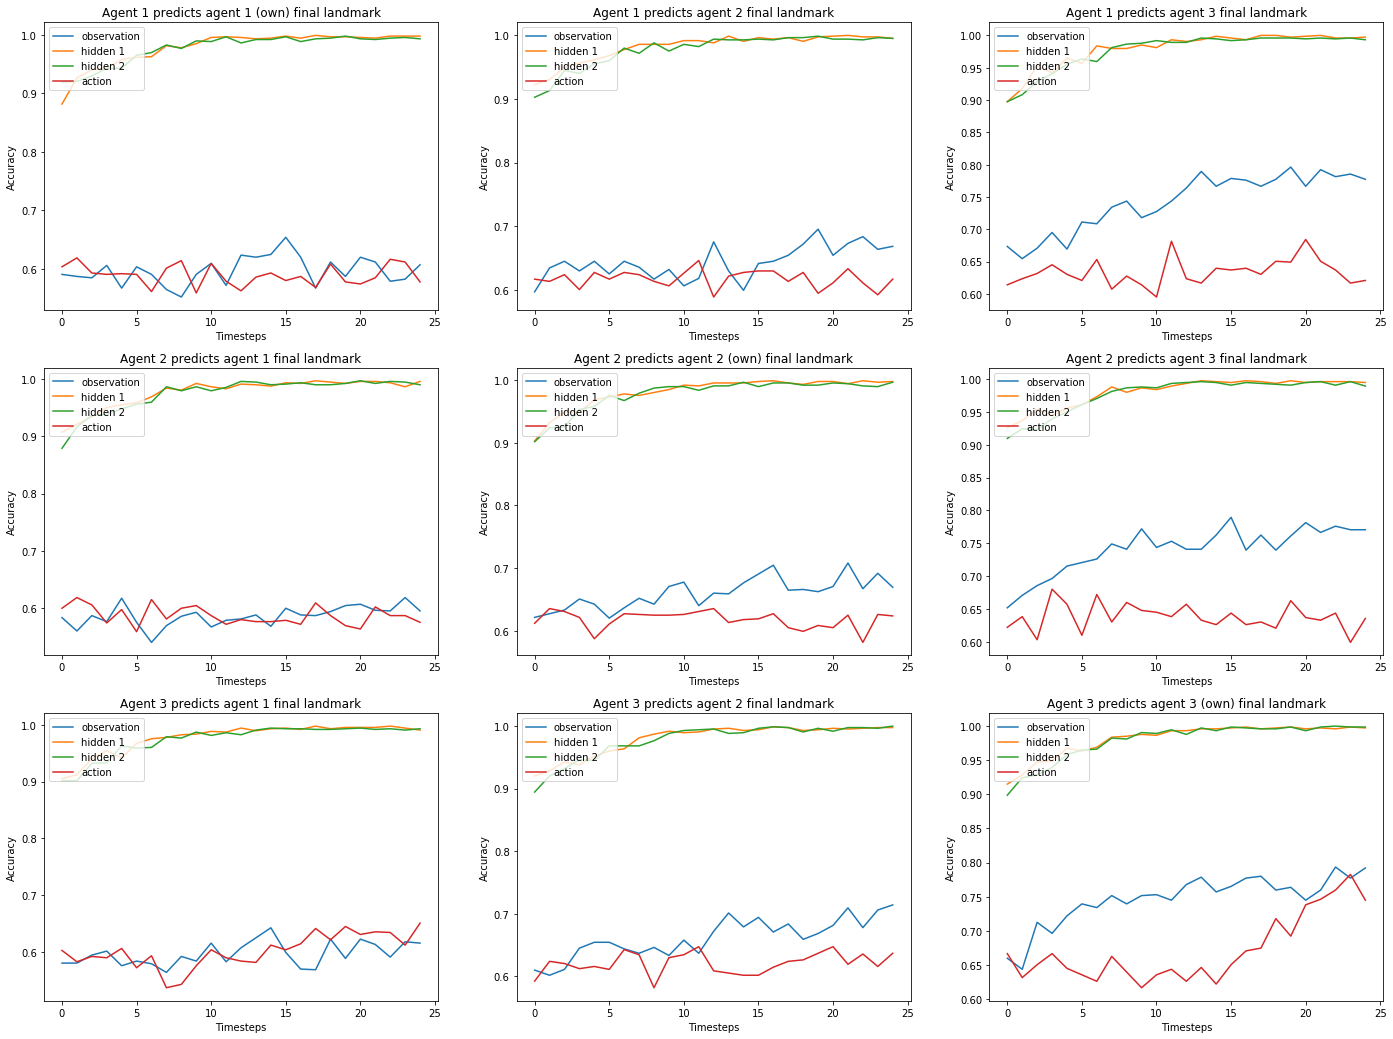

In [7]:
plt.figure(figsize=(24, 18))
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i*3 + j + 1)
        plt.plot(acc[i, j, :, :, 1])
        plt.ylabel('Accuracy')
        plt.xlabel('Timesteps')
        plt.title('Agent %d predicts agent %d%s final landmark' % (i + 1, j + 1, ' (own)' if i == j else ''))
        plt.legend(['observation', 'hidden 1', 'hidden 2', 'action'], loc='upper left')